In [326]:
import os
import numpy as np
import pandas as pd
import scipy.io

import seaborn as sns
import matplotlib.pyplot as plt
from ipywidgets import interactive
%matplotlib inline

## Load data

In [365]:
meta = pd.read_excel('C:/Users/lan/Documents/repos/inter/mat/adp_dataset_master.xlsx', index_col=None)
meta = meta[meta.seg == 'segmented']
meta = meta[['mouse','date','area']]

In [491]:
nset = len(meta.index); ncell = []; nori = 8; nisi = 3; nframe_trial = 223
dir_name = 'C:\\Users\\lan\\Documents\\repos\\inter\\mat\\'

vis_ad = np.empty([0,1]); vis_tg = np.empty([0,1]); well_fit = np.empty([0,1])
ori_pref = np.empty([0,nisi]); fit_param = np.empty([0,7,nisi])
dfof_ad = np.empty([0,1]); dfof_tg = np.empty([0,nori,nisi])
dfof_ad_std = np.empty([0,1]); dfof_tg_std = np.empty([0,nori,nisi])
trace = np.empty([0,nori,nisi,nframe_trial])

for iset in np.arange(nset):
    dir_sub = str(meta.area[iset]) + '_i' + str(meta.mouse[iset]) + '_' + str(meta.date[iset])

    cell_prop = scipy.io.loadmat(os.path.join(dir_name, dir_sub, 'cell_property_loose' + '.mat'))
    dfof = scipy.io.loadmat(os.path.join(dir_name, dir_sub, 'dfof' + '.mat'))
    trace_align = scipy.io.loadmat(os.path.join(dir_name, dir_sub, 'trace_aligned' + '.mat'))
    fit_tuning = scipy.io.loadmat(os.path.join(dir_name, dir_sub, 'fit_tuning_isi3' + '.mat'))
    
    ncell.append(len(cell_prop['vis_cell_ad']))    
    vis_ad = np.concatenate((vis_ad, cell_prop['vis_cell_ad']), axis=0)
    vis_tg = np.concatenate((vis_tg, cell_prop['vis_cell_noad_tg']), axis=0)
    well_fit = np.concatenate((well_fit, cell_prop['well_fit_cell']), axis=0)
    
    ori_pref = np.concatenate((ori_pref, cell_prop['ori_pref']), axis=0)
    fit_param = np.concatenate((fit_param, fit_tuning['fit_param']), axis=0)

    dfof_ad = np.concatenate((dfof_ad, dfof['dfof_ad']), axis=0)
    dfof_ad_std = np.concatenate((dfof_ad_std, dfof['dfof_ad_std']), axis=0)
    dfof_tg = np.concatenate((dfof_tg, dfof['dfof_tg']), axis=0)
    dfof_tg_std = np.concatenate((dfof_tg_std, dfof['dfof_tg_std']), axis=0)
    
    trace_flat = np.empty([ncell[iset],nori,nisi,nframe_trial]);
    for icell in np.arange(ncell[iset]):
        for iori in np.arange(nori):
            for iisi in np.arange(nisi):
                trace_flat[icell][iori][iisi][:] = trace_align['trace_avg'][icell][iori][iisi].flatten()
    trace = np.vstack((trace,trace_flat))

ncell, vis_ad.shape, vis_tg.shape, well_fit.shape, ori_pref.shape, fit_param.shape, dfof_ad.shape, dfof_tg.shape, trace.shape

([97, 69, 53, 103, 39, 33, 93, 52],
 (539, 1),
 (539, 1),
 (539, 1),
 (539, 3),
 (539, 7, 3),
 (539, 1),
 (539, 8, 3),
 (539, 8, 3, 223))

In [367]:
meta['ncell'] = ncell
# meta = meta.replace({'area' : { 'V1':1, 'LM':2, 'LI':3 }})
meta

,mouse,date,area,ncell
0,1322,200803,V1,97
1,1322,200804,LM,69
2,1322,200806,LI,53
3,1323,200720,V1,103
4,1323,200721,LM,39
5,1323,200723,LI,33
6,1324,200728,V1,93
7,1324,200729,LM,52


In [369]:
mouse_cell = [item for item, count in zip(meta.mouse, meta.ncell) for i in range(count)]
area_cell = [item for item, count in zip(meta.area, meta.ncell) for i in range(count)]
meta_cell = pd.DataFrame({'mouse': mouse_cell, 'area': area_cell})
meta_cell

,mouse,area
0,1322,V1
1,1322,V1
2,1322,V1
3,1322,V1
4,1322,V1
...,...,...
534,1324,LM
535,1324,LM
536,1324,LM
537,1324,LM


## Adaptation magnitude

adaptation mag = response to target ori==0 with adapter / response to adapter - 1  
cell selection: vis_ad only, no dfof_ad thresholding

In [406]:
adp_mag = dfof_tg[:,0,[1,2]] / dfof_ad - 1

meta_cell_750 = meta_cell.copy(); meta_cell_750['isi'] = 750
meta_cell_250 = meta_cell.copy(); meta_cell_250['isi'] = 250
meta_cell_isi = pd.concat([meta_cell_750, meta_cell_250], ignore_index=True)

df_adp_mag = meta_cell_isi.copy()
df_adp_mag['adp_mag'] = adp_mag.flatten('F')
df_adp_mag['dfof_ad'] = np.concatenate((dfof_ad, dfof_ad), axis=0)

df_adp_mag['vis_ad'] = np.concatenate((vis_ad, vis_ad), axis=0)
df_adp_mag = df_adp_mag[ df_adp_mag['vis_ad'] == 1 ]
df_adp_mag.reset_index()

,index,mouse,area,isi,adp_mag,dfof_ad,vis_ad
0,0,1322,V1,750,-0.239962,0.083296,1.0
1,1,1322,V1,750,-0.267440,0.079051,1.0
2,2,1322,V1,750,0.092123,0.089755,1.0
3,3,1322,V1,750,-0.258139,0.149961,1.0
4,4,1322,V1,750,-0.049561,0.242218,1.0
...,...,...,...,...,...,...,...
963,1072,1324,LM,250,-0.815490,0.010215,1.0
964,1073,1324,LM,250,-0.744829,0.040586,1.0
965,1074,1324,LM,250,-0.274517,0.037092,1.0
966,1076,1324,LM,250,-1.451877,0.035262,1.0


In [408]:
df_adp_mag[['adp_mag','area','isi']].groupby(['area','isi'], sort=False).describe()

adp_mag                                                              \
           count      mean       std       min       25%       50%       75%   
area isi                                                                       
V1   750   267.0 -0.180326  0.665569 -2.163029 -0.469887 -0.221775  0.077338   
     250   267.0 -0.325477  0.616129 -3.004134 -0.654125 -0.378501 -0.058079   
LM   750   141.0 -0.051040  0.598336 -1.923241 -0.409122 -0.033545  0.211504   
     250   141.0 -0.648543  0.626268 -3.042202 -0.981837 -0.712494 -0.320640   
LI   750    76.0 -0.291396  0.618888 -2.013799 -0.698398 -0.270519  0.103593   
     250    76.0 -0.953516  0.612308 -2.862550 -1.238230 -0.989792 -0.658323   

                    
               max  
area isi            
V1   750  3.502958  
     250  3.622513  
LM   750  2.132582  
     250  1.490129  
LI   750  1.569319  
     250  0.894041

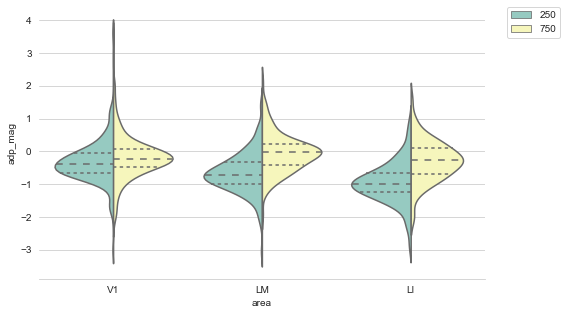

In [404]:
sns.set_style("whitegrid")
plt.figure(figsize=(8,5))
sns.violinplot(data=df_adp_mag, x="area", y="adp_mag", hue="isi",
               split=True, inner="quart", palette="Set3")
sns.despine(left=True)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

### add dfof_ad thresholding

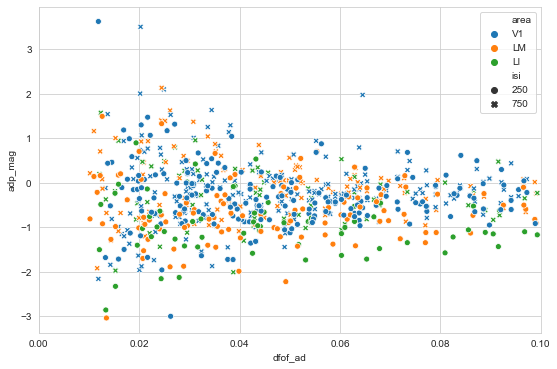

In [447]:
plt.figure(figsize=(9,6))
sns.scatterplot(data=df_adp_mag, x="dfof_ad", y="adp_mag", hue="area", style="isi")
# plt.xlim([0,0.8]);
plt.xlim([0,0.1]);

In [477]:
df = df_adp_mag.sort_values(by=['dfof_ad'])
df1 = df[df.isi == 750]
df2 = df[df.isi == 250]

def f(win):
    plt.figure(figsize=(15,5))
    plt.plot(df1.dfof_ad, df1['adp_mag'].rolling(win, min_periods=1).mean(), alpha=0.7)
    plt.plot(df2.dfof_ad, df2['adp_mag'].rolling(win, min_periods=1).mean(), alpha=0.7)
    plt.legend(['isi = 750', 'isi = 250'])
    plt.xlim([0,0.1])
    plt.xlabel('dfof_ad')
    plt.ylabel('adaptation mag rolling mean')
    plt.show()

interactive_plot = interactive(f, win=(2, 20))
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(IntSlider(value=11, description='win', max=20, min=2), Output(layout=Layout(height='350p…

In [478]:
def f(win):
    plt.figure(figsize=(15,5))
    plt.plot(df1.dfof_ad, df1['adp_mag'].rolling(win, min_periods=1).std(), alpha=0.7)
    plt.plot(df2.dfof_ad, df2['adp_mag'].rolling(win, min_periods=1).std(), alpha=0.7)
    plt.legend(['isi = 750', 'isi = 250'])
    plt.xlim([0,0.1])
    plt.xlabel('dfof_ad')
    plt.ylabel('adaptation mag rolling std')
    plt.show()

interactive_plot = interactive(f, win=(2, 20))
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(IntSlider(value=11, description='win', max=20, min=2), Output(layout=Layout(height='350p…

cell selection: vis_ad only, with dfof_ad thresholding at 0.03

In [483]:
df_adp_mag_thres = df_adp_mag[df_adp_mag.dfof_ad >= 0.03]
df_adp_mag_thres.reset_index()

,index,mouse,area,isi,adp_mag,dfof_ad,vis_ad
0,0,1322,V1,750,-0.239962,0.083296,1.0
1,1,1322,V1,750,-0.267440,0.079051,1.0
2,2,1322,V1,750,0.092123,0.089755,1.0
3,3,1322,V1,750,-0.258139,0.149961,1.0
4,4,1322,V1,750,-0.049561,0.242218,1.0
...,...,...,...,...,...,...,...
753,1067,1324,LM,250,-1.037747,0.047524,1.0
754,1073,1324,LM,250,-0.744829,0.040586,1.0
755,1074,1324,LM,250,-0.274517,0.037092,1.0
756,1076,1324,LM,250,-1.451877,0.035262,1.0


In [485]:
df_adp_mag_thres[['adp_mag','area','isi']].groupby(['area','isi'], sort=False).describe()

adp_mag                                                              \
           count      mean       std       min       25%       50%       75%   
area isi                                                                       
V1   750   215.0 -0.164490  0.492664 -1.875533 -0.395995 -0.188318  0.040594   
     250   215.0 -0.362663  0.443836 -1.729659 -0.648102 -0.399921 -0.124511   
LM   750   108.0 -0.100791  0.436052 -1.089206 -0.373513 -0.076079  0.111626   
     250   108.0 -0.635745  0.510077 -2.225924 -0.915844 -0.686542 -0.359696   
LI   750    56.0 -0.321286  0.502430 -2.013799 -0.632570 -0.270519 -0.025623   
     250    56.0 -0.922097  0.467841 -1.738642 -1.185452 -0.971112 -0.737692   

                    
               max  
area isi            
V1   750  1.972312  
     250  1.149798  
LM   750  1.369365  
     250  0.703521  
LI   750  0.951508  
     250  0.530749

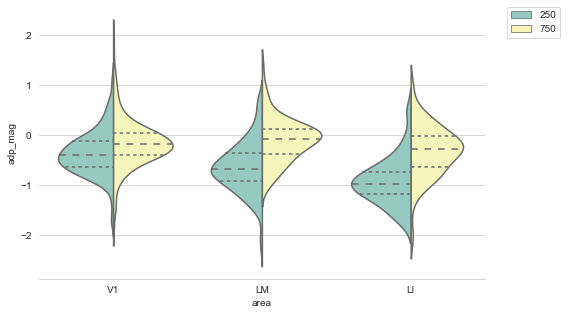

In [486]:
sns.set_style("whitegrid")
plt.figure(figsize=(8,5))
sns.violinplot(data=df_adp_mag_thres, x="area", y="adp_mag", hue="isi",
               split=True, inner="quart", palette="Set3")
sns.despine(left=True)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

# Adaptation tuning bias

## Misc
### Adaptation increase variability (?)
for ori=0 target after adaptation, fano factor is higher than adapter

In [523]:
adp_fano_tg = dfof_tg_std[:,0,[1,2]] / dfof_tg[:,0,[1,2]]
adp_fano_ad = dfof_ad_std / dfof_ad
adp_fano = (adp_fano_tg - adp_fano_ad) / (adp_fano_tg + adp_fano_ad) # range [-1,1], meaning fano factor de/increase after adp
# adp_fano = (adp_fano_tg - adp_fano_ad) / (adp_fano_ad)

df_adp_fano = meta_cell_isi.copy()
df_adp_fano['adp_fano'] = adp_fano.flatten('F')
df_adp_fano['dfof_ad'] = np.concatenate((dfof_ad, dfof_ad), axis=0)

df_adp_fano['vis_ad'] = np.concatenate((vis_ad, vis_ad), axis=0)
df_adp_fano = df_adp_fano[ df_adp_fano['vis_ad'] == 1 ]

df_adp_fano = df_adp_fano[df_adp_fano.dfof_ad >= 0.03]
df_adp_fano.reset_index()

,index,mouse,area,isi,adp_fano,dfof_ad,vis_ad
0,0,1322,V1,750,0.198528,0.083296,1.0
1,1,1322,V1,750,0.249547,0.079051,1.0
2,2,1322,V1,750,0.224684,0.089755,1.0
3,3,1322,V1,750,0.069735,0.149961,1.0
4,4,1322,V1,750,0.079733,0.242218,1.0
...,...,...,...,...,...,...,...
753,1067,1324,LM,250,1.108319,0.047524,1.0
754,1073,1324,LM,250,0.570123,0.040586,1.0
755,1074,1324,LM,250,0.132217,0.037092,1.0
756,1076,1324,LM,250,3.288224,0.035262,1.0


In [524]:
df_adp_fano[['adp_fano','area','isi']].groupby(['area','isi'], sort=False).describe()

adp_fano                                                       \
            count      mean        std         min       25%       50%   
area isi                                                                 
V1   750    215.0  0.068709   1.856949  -25.149053 -0.017004  0.107881   
     250    215.0  0.293706   0.631809   -3.922463  0.062876  0.196965   
LM   750    108.0  0.110120   0.277552   -0.410187 -0.061396  0.060359   
     250    108.0 -0.692155  12.628637 -130.179952  0.150847  0.420604   
LI   750     56.0  1.592768  10.445240   -0.438364 -0.038571  0.091560   
     250     56.0  4.518923  20.325010  -52.913921  0.389974  0.826239   

                               
               75%        max  
area isi                       
V1   750  0.223407   7.313785  
     250  0.407071   5.260362  
LM   750  0.225482   1.206498  
     250  0.743679   3.527858  
LI   750  0.251320  78.291368  
     250  1.802445  97.316446

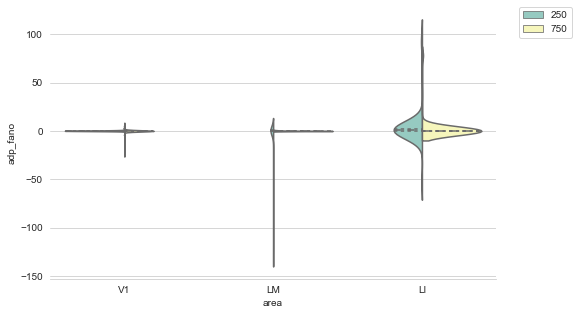

In [528]:
sns.set_style("whitegrid")
plt.figure(figsize=(8,5))
sns.violinplot(data=df_adp_fano, x="area", y="adp_fano", hue="isi",
               split=True, inner="quart", palette="Set3")
sns.despine(left=True)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);
# plt.ylim([-2,2]);